In [6]:
import os 
import pandas as pd
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
plt.style.use(['science', 'ieee', 'notebook', 'no-latex'])
# from pvlib import pvlib.iotools.read_epw as read_epw

file_path = os.path.join('H1b_Th-D_2021.epw)

SyntaxError: unterminated string literal (detected at line 11) (140360423.py, line 11)

# Modèle analytique

In [2]:
import math
import pandas as pd

def temperature_sol_epw(epw_file, 
                        profondeur, 
                        amplitude_surface, 
                        diffusivite_thermique):
    """
    Calcule la température du sol pour chaque heure à partir des données d'un fichier EPW.

    :param epw_file: Chemin vers le fichier .epw
    :param profondeur: Profondeur dans le sol (mètres)
    :param amplitude_surface: Amplitude de la variation de température en surface (°C)
    :param periode: Période du cycle thermique (secondes)
    :param diffusivite_thermique: Diffusivité thermique du sol (m²/s)
    :return: DataFrame contenant la température du sol pour chaque heure
    """
    
    # Lecture du fichier .epw
    with open(epw_file, 'r') as file:
        # Saute les lignes d'entête et charge les données utiles
        for _ in range(8):
            next(file)
        data = pd.read_csv(file, header=None)
    periode = len(data)*3600
    # Constantes
    omega = 2 * math.pi / periode
    D = math.sqrt(2 * diffusivite_thermique / omega)
    

    
    # La température extérieure se trouve en colonne 6 (index 6 car indexé à 0)
    temperature_ext = data[6]
    jour_le_plus_froid = temperature_ext[temperature_ext == temperature_ext.min()].index[0]
    print(jour_le_plus_froid)
    # Calcul de la température moyenne annuelle
    temperature_moyenne_surface = temperature_ext.mean()

    # Calcul des températures du sol
    temperatures_sol = []
    for heure, temp_ext in enumerate(temperature_ext):
        temperature = (temperature_moyenne_surface +
                       amplitude_surface * math.exp(-profondeur / D) *
                       math.cos(omega * (heure-jour_le_plus_froid*24) * 3600 - profondeur / D))
        temperatures_sol.append(temperature)
    
    # Création du DataFrame résultat
    result = pd.DataFrame({
        'Heure': range(1, len(temperature_ext) + 1),
        'Temperature_Sol': temperatures_sol,
        'Temperature_Ext': temperature_ext
    })
    
    return result, temperature_ext, data, jour_le_plus_froid

In [3]:
result, temperature_ext, data, jour_le_plus_froid = temperature_sol_epw(
    epw_file=file_path,
    profondeur=0.05,  # 2 mètres de profondeur
    amplitude_surface=10.0,  # amplitude de variation en surface
    diffusivite_thermique=1e-6  # diffusivité thermique typique
)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\simon\\python-scripts\\DesignBuilder\\PreProcess\\ModeleDeSol\\meteo\\La_Rochelle-hour.epw'

In [ ]:
# Ajouter une colonne pour les mois (chaque mois correspond à environ 730 heures)
result["Month"] = ((result["Heure"] // 730) + 1).astype(int)

# Calcul de la moyenne mensuelle
monthly_avg = round(result.groupby("Month")["Temperature_Sol"].mean(), 2)

# Création du DataFrame des moyennes mensuelles
monthly_avg_df = monthly_avg.reset_index()
monthly_avg_df.columns = ["Month", "Average Flattened Temperature (°C)"]

In [4]:
monthly_avg_df

NameError: name 'monthly_avg_df' is not defined

Text(0, 0.5, 'Temp - C')

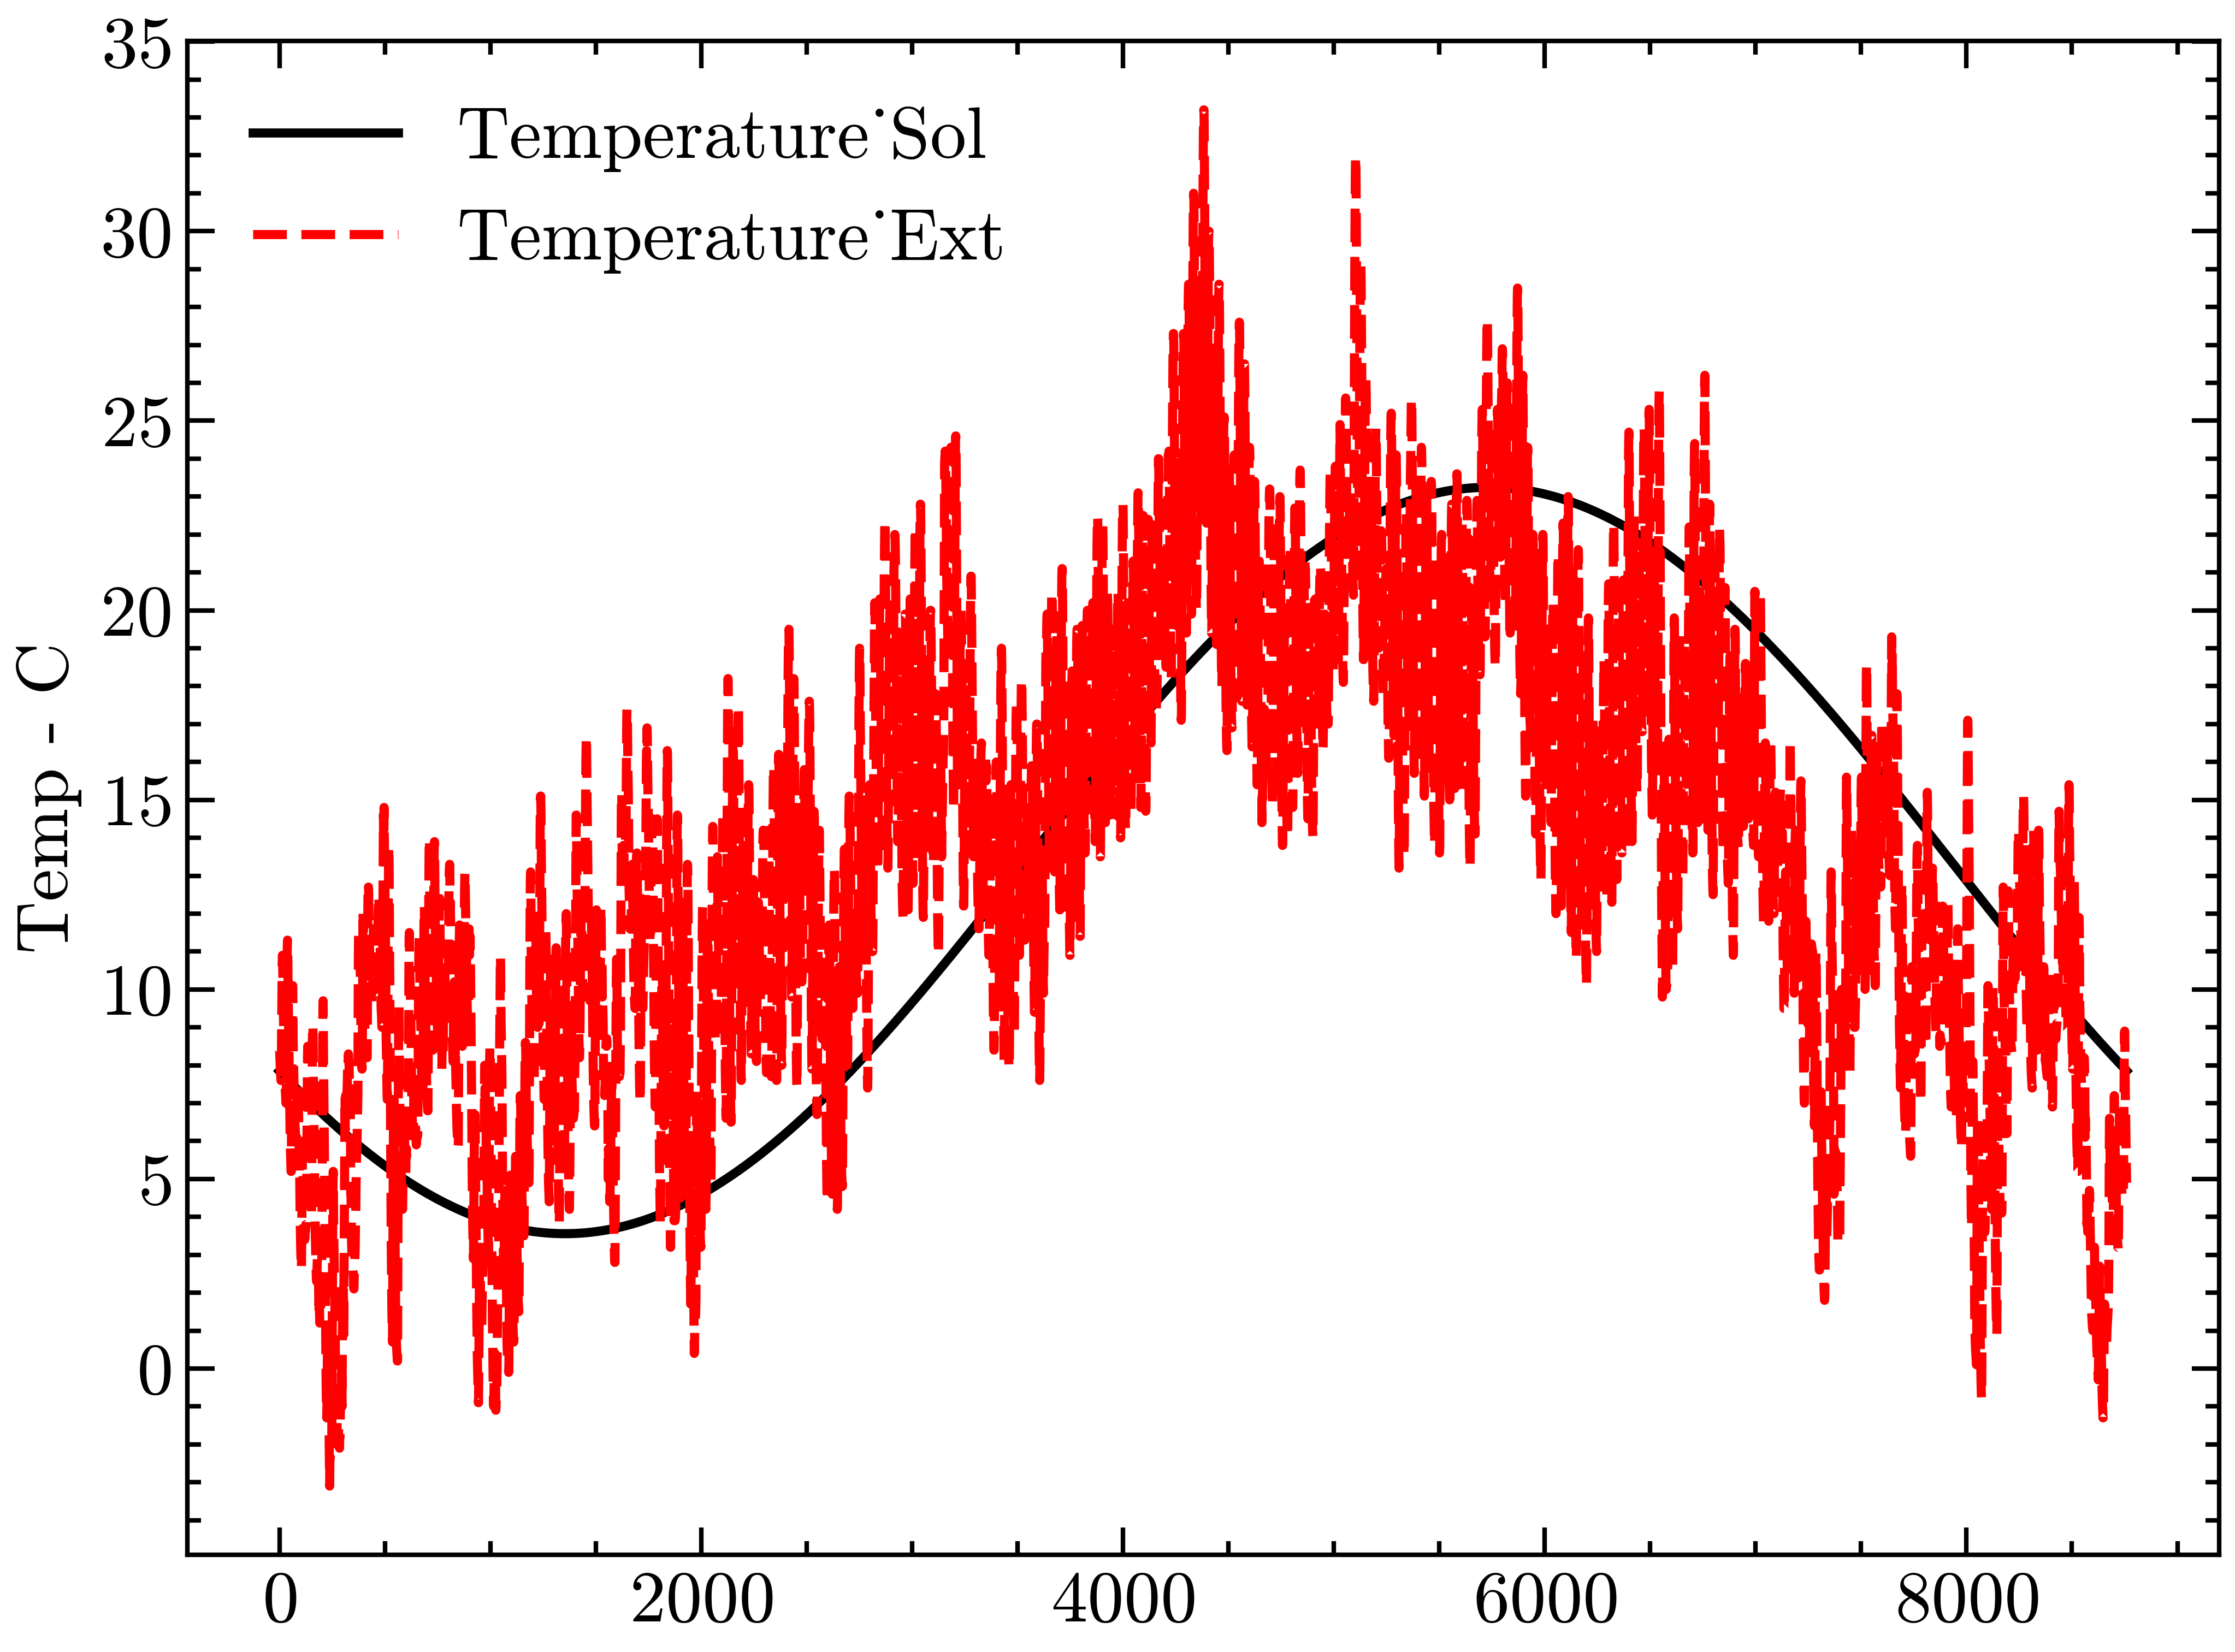

In [129]:
result.Temperature_Sol.plot(label = 'Temperature_Sol')
result.Temperature_Ext.plot(label = 'Temperature_Ext')
plt.legend()
plt.ylabel('Temp - C')

In [117]:
result

,Heure,Temperature_Sol,Temperature_Ext
0,1,8.475896,8.4
1,2,8.470165,8.4
2,3,8.464436,8.2
3,4,8.458709,8.1
4,5,8.452986,7.9
...,...,...,...
8755,8756,8.504591,6.5
8756,8757,8.498847,6.1
8757,8758,8.493106,5.7
8758,8759,8.487367,5.2


# Sinusoïde bricolée

C:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 966 (\N{GREEK SMALL LETTER PHI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


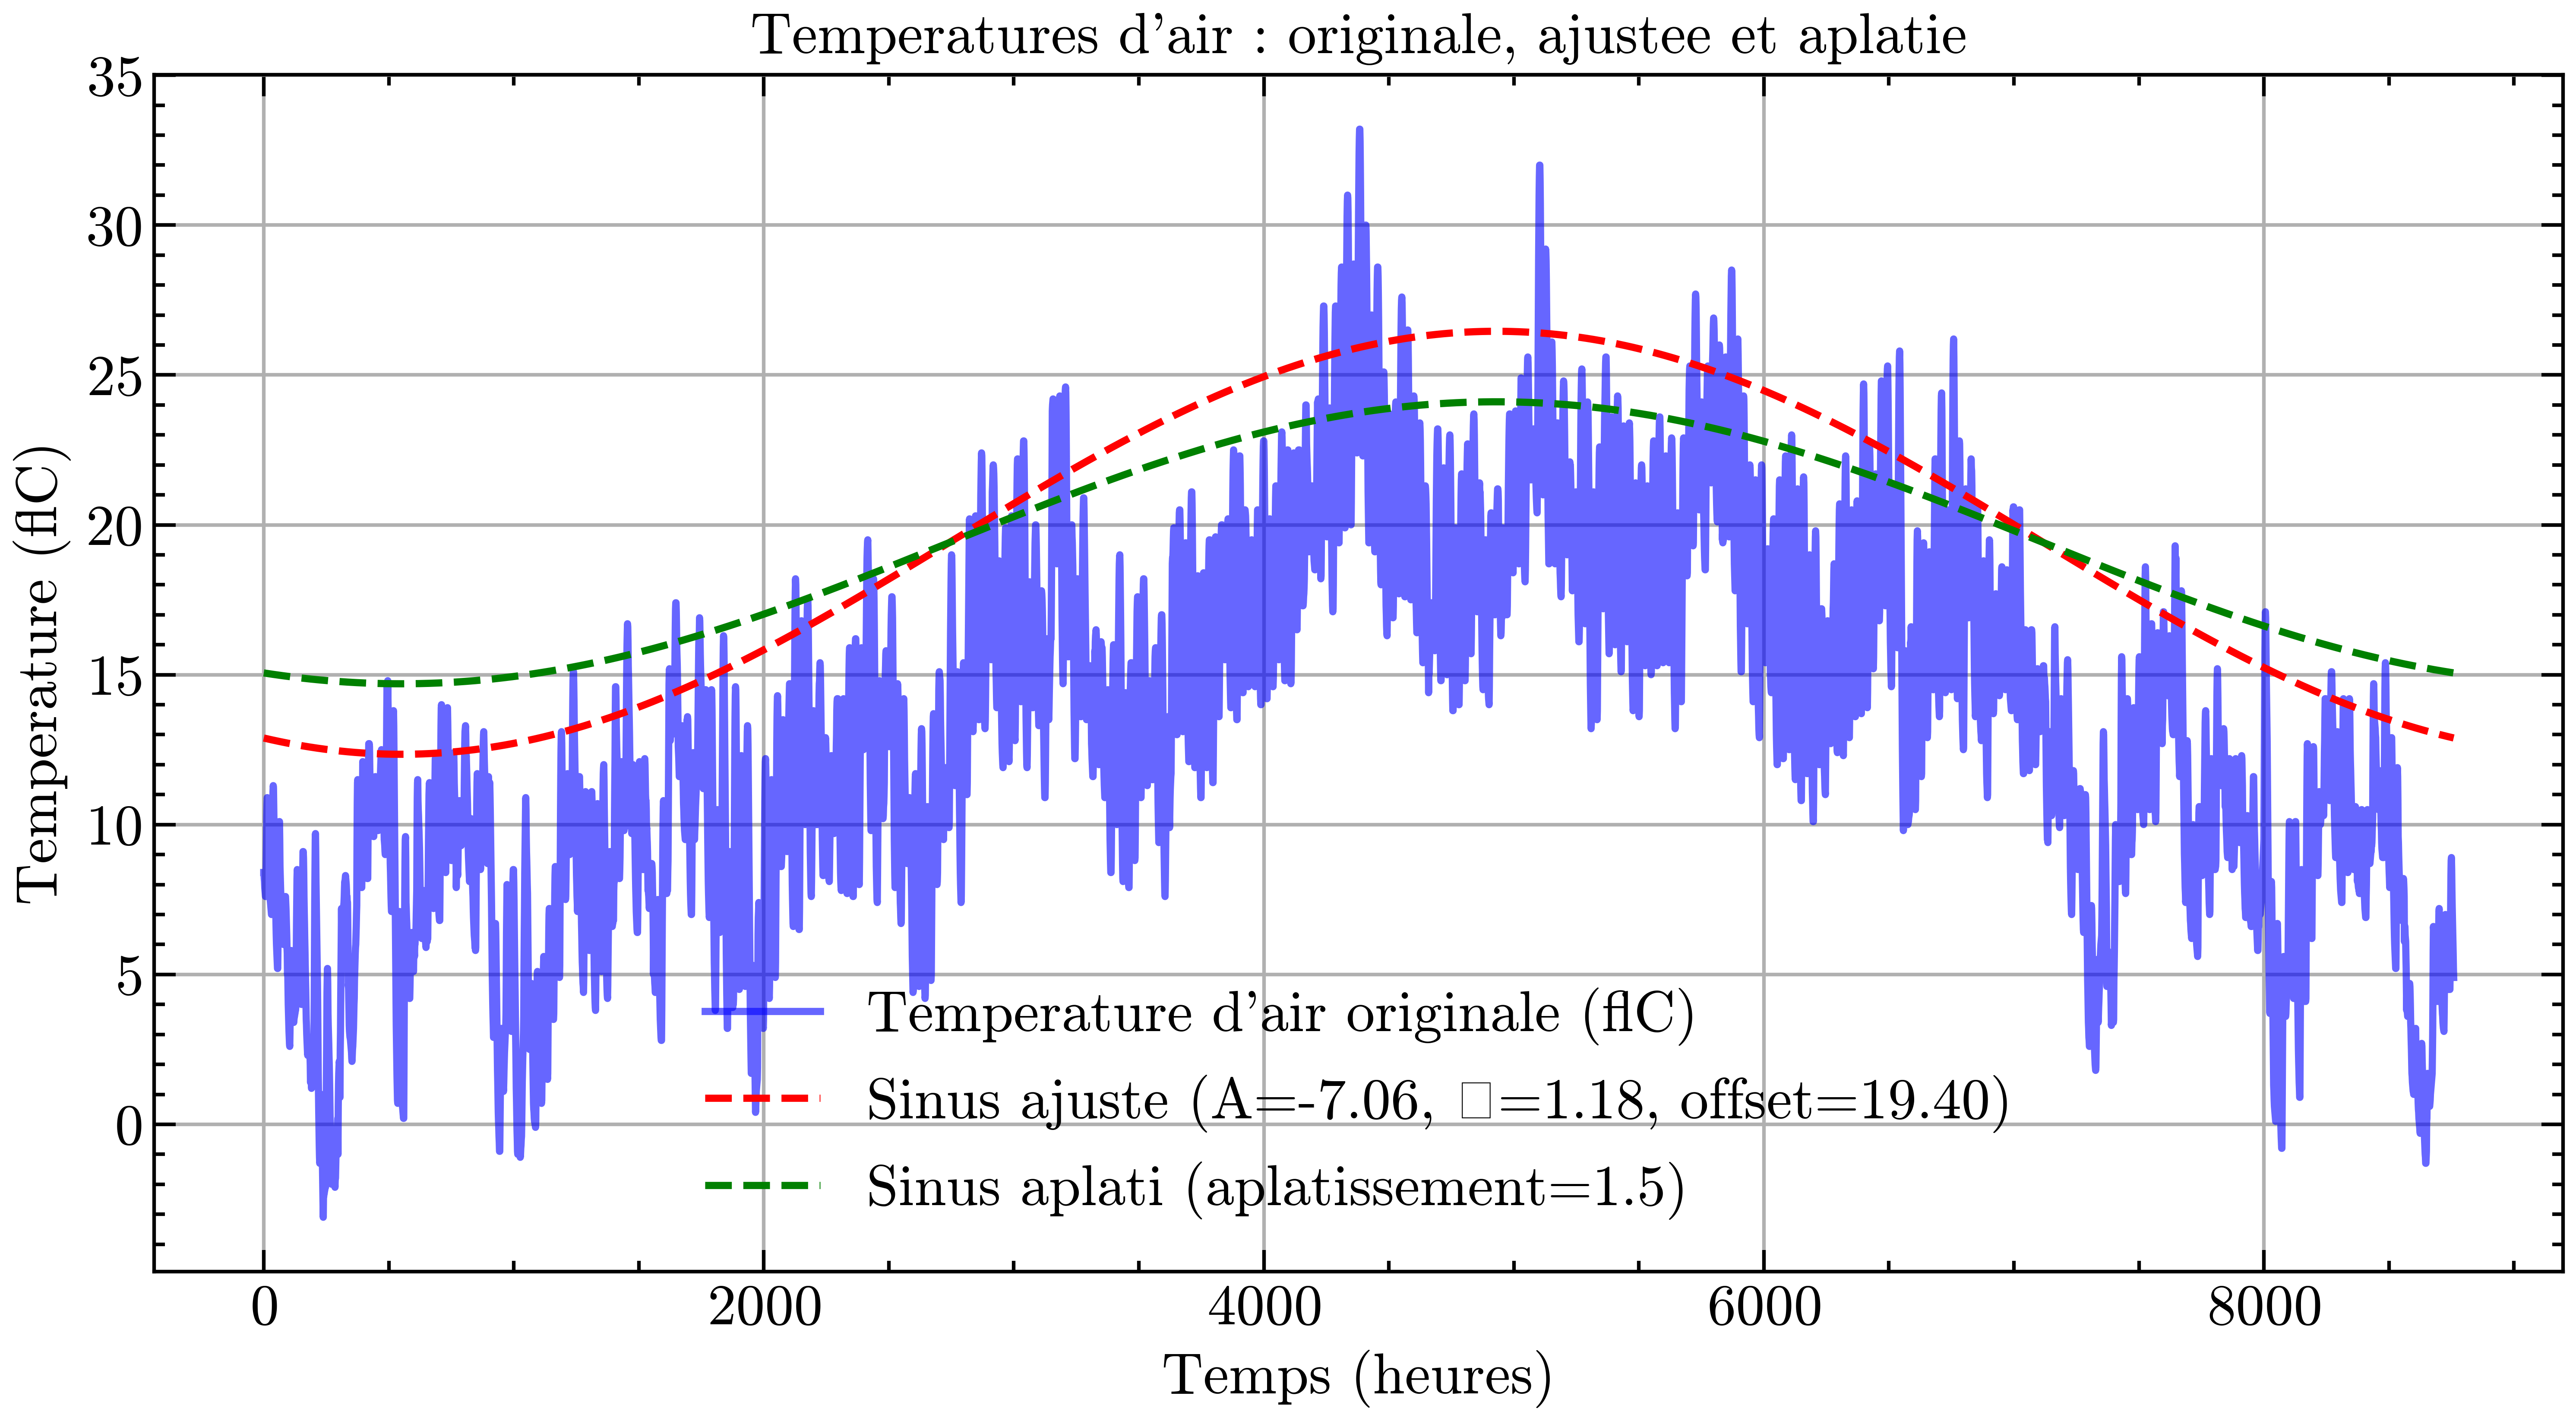

,Month,Average Flattened Temperature (°C)
0,1,"14,79"
1,2,"15,1"
2,3,"16,56"
3,4,"18,78"
4,5,"21,17"
5,6,"23,08"
6,7,"24,01"
7,8,"23,7"
8,9,"22,24"
9,10,"20,02"


In [104]:
# Fonction sinus pour le fit
def sinusoidal(t, amplitude, phase, offset):
    """
    Modèle sinusoidal pour ajuster les données de température.
    
    :param t: Temps (en heures).
    :param amplitude: Amplitude de l'onde.
    :param phase: Phase de l'onde (en radians).
    :param offset: Décalage vertical.
    """
    return amplitude * np.sin(2 * np.pi * t / 8760 + phase) + offset

# Extraction des données à partir du fichier
epw_data = pd.read_csv(file_path, skiprows=8, header=None)
temp_air = epw_data[6]  # Température de l'air (colonne 6)
time = np.arange(len(temp_air))  # Temps en heures

# Ajustement des données avec la fonction sinus
initial_guess = [10, 0, temp_air.mean()]  # Amplitude, phase initiale, offset initial
params, _ = curve_fit(sinusoidal, time, temp_air, p0=initial_guess)
# Paramètres optimisés
amplitude_fit, phase_fit, offset_fit = params
offset_fit = offset_fit+6


def flattened_sinusoidal(t, amplitude, phase, offset, flattening):
    """
    Modèle sinusoidal aplati pour ajuster les données de température.
    
    :param t: Temps (en heures).
    :param amplitude: Amplitude de l'onde.
    :param phase: Phase de l'onde (en radians).
    :param offset: Décalage vertical.
    :param flattening: Coefficient d'aplatissement (1 = sinus pur, >1 = aplati).
    """
    return amplitude * np.sin(2 * np.pi * t / 8760 + phase) / flattening + offset
fitted_temp = flattened_sinusoidal(time, 
                                      amplitude_fit, 
                                      phase_fit, offset = offset_fit, flattening = 1)
# Nouveau coefficient d'aplatissement
flattening_coefficient = 1.5  # Par défaut, >1 pour aplatir
# plt.plot(time, fitted_temp, label=f"Sinus ajusté (A={amplitude_fit:.2f}, φ={phase_fit:.2f}, offset={offset_fit:.2f})", color="red")

# Génération des données ajustées avec aplatissement
flattened_temp = flattened_sinusoidal(time, 
                                      amplitude_fit, 
                                      phase_fit, 
                                      offset_fit, 
                                      flattening_coefficient)

# Tracer les données originales, ajustées normales, et aplaties
plt.figure(figsize=(12, 6))
plt.plot(time, temp_air, label="Temperature d'air originale (°C)", color="blue", alpha=0.6)
plt.plot(time, fitted_temp, label=f"Sinus ajuste (A={amplitude_fit:.2f}, φ={phase_fit:.2f}, offset={offset_fit:.2f})", color="red")
plt.plot(time, flattened_temp, label=f"Sinus aplati (aplatissement={flattening_coefficient})", color="green", linestyle="--")
plt.xlabel("Temps (heures)")
plt.ylabel("Temperature (°C)")
plt.title("Temperatures d'air : originale, ajustee et aplatie")
plt.legend()
plt.grid()
plt.show()



# Création d'un DataFrame contenant les données de température et le temps
data = pd.DataFrame({
    "Time (hours)": time,
    "Flattened Temperature": flattened_temp
})

# Ajouter une colonne pour les mois (chaque mois correspond à environ 730 heures)
data["Month"] = ((data["Time (hours)"] // 730) + 1).astype(int)

# Calcul de la moyenne mensuelle
monthly_avg = round(data.groupby("Month")["Flattened Temperature"].mean(), 2)

# Création du DataFrame des moyennes mensuelles
monthly_avg_df = monthly_avg.reset_index()
monthly_avg_df.columns = ["Month", "Average Flattened Temperature (°C)"]


def replace_dots_with_commas(df):
    """
    Remplace tous les points par des virgules dans un DataFrame pour les colonnes contenant des données numériques.

    :param df: DataFrame contenant les données.
    :return: Nouveau DataFrame avec les points remplacés par des virgules.
    """
    # Appliquer la conversion sur toutes les colonnes
    df_with_commas = df.applymap(lambda x: str(x).replace('.', ',') if isinstance(x, (float, int)) else x)
    return df_with_commas

replace_dots_with_commas(monthly_avg_df)

# Modèle analytique

238


<Axes: >

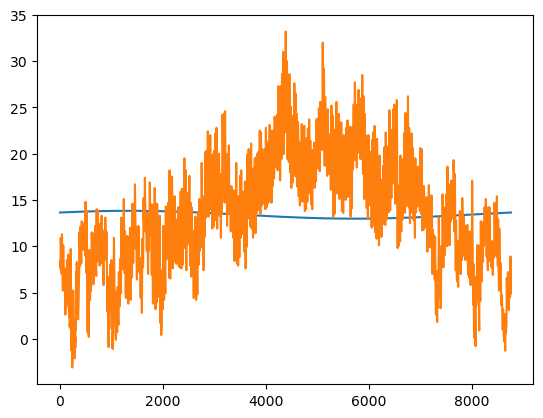

In [90]:
result['Temperature_Sol'].plot()
result['Temperature_Ext'].plot()